# Imports

In [2]:
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Obtain dataset from Kaggle

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download shravankumar9892/image-colorization

100% 2.10G/2.10G [01:35<00:00, 22.5MB/s]
100% 2.10G/2.10G [01:35<00:00, 23.7MB/s]


In [5]:
!ls

image-colorization.zip	kaggle.json  sample_data


In [6]:
!unzip image-colorization.zip

Archive:  image-colorization.zip
  inflating: ab/ab/ab1.npy           
  inflating: ab/ab/ab2.npy           
  inflating: ab/ab/ab3.npy           
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: l/gray_scale.npy        


# Dataset class
This class handles loading and processing of images if needed.

In [48]:
class ImageDataset(Dataset):
  def __init__(self, l_file, ab_files, transform = None):
    self.l_data = np.expand_dims(np.load(l_file), axis = -1).astype('float32') / 255.0

    all_ab_files = [np.load(i) for i in ab_files]
    self.ab_data = np.concatenate(all_ab_files, axis = 0).astype('float32') / 255.0
    self.transform = transform

  def __len__(self):
    return len(self.l_data)

  def __getitem__(self, idx):
    gray_tensor = torch.tensor(self.l_data[idx], dtype = torch.float32).permute(2, 1, 0)
    lab_tensor = torch.tensor(self.ab_data[idx], dtype = torch.float32).permute(2, 1, 0)

    if self.transform:
      gray_tensor = self.transform(gray_tensor)
      lab_tensor = self.transform(lab_tensor)

    return (gray_tensor, lab_tensor)

# Load the dataset and split to train and test
80% of the dataset goes to training and the remaining 20% is for testing.
The training set is divided into 4 chunks in order to fully train the model on the set

In [49]:
dataset = ImageDataset(l_file = '/content/l/gray_scale.npy',
                       ab_files = ['/content/ab/ab/ab1.npy',
                                   '/content/ab/ab/ab2.npy',
                                   '/content/ab/ab/ab3.npy'])

In [56]:
train_n = int(0.9 * len(dataset))
test_n = len(dataset) - train_n
train_set, test_set = torch.utils.data.random_split(dataset, [train_n, test_n])

In [57]:
train_n, test_n

(22500, 2500)

In [58]:
chunks = 4
chunk_size = int(train_n / chunks)
train_set_chunks = [Subset(train_set, range(chunk_size * i, chunk_size * (i + 1))) for i in range(chunks)]

In [59]:
len(train_set_chunks), len(train_set_chunks[0]), len(train_set_chunks[1]), len(train_set_chunks[2]), len(train_set_chunks[3])

(4, 5625, 5625, 5625, 5625)

In [60]:
train_loader_chunks = [DataLoader(chunk, shuffle = True, batch_size = 32) for chunk in train_set_chunks]
test_loader = DataLoader(test_set, shuffle = False, batch_size = 32)

# Data Visualization

In [61]:
def convert_to_rgb(lab_image, grayscaled_image):
  # Some preprocessing of tensors to numpy
  grayscaled_image = grayscaled_image.permute(2, 1, 0).detach().cpu().numpy()
  lab_image = lab_image.permute(2, 1, 0).detach().cpu().numpy()
  lab_image = lab_image * 255
  grayscaled_image = grayscaled_image * 255

  rgb_image = np.zeros((grayscaled_image.shape[0], grayscaled_image.shape[1], 3))

  rgb_image[..., 0] = grayscaled_image[..., 0] # Obtain lightness from grayscaled images
  rgb_image[..., 1:]= lab_image # Obtain everything else from lab images

  rgb_image = rgb_image.astype('uint8')
  rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_LAB2RGB)
  return rgb_image

In [62]:
batch = next(iter(train_loader_chunks[0]))

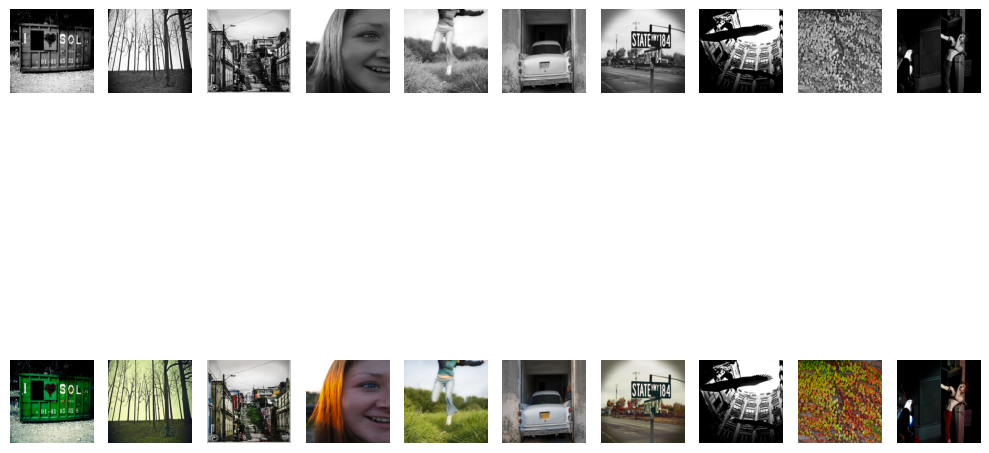

In [63]:
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.subplot(2, 10, i + 1)
  plt.imshow(batch[0][i].permute(2, 1, 0).detach().cpu().numpy(), cmap = 'gray')
  plt.axis('off')

  plt.subplot(2, 10, i + 11)
  plt.imshow(convert_to_rgb(batch[1][i], batch[0][i]))
  plt.axis('off')
plt.tight_layout()
plt.show()

# CAE Model Architecture (UNet Architecture)

In [64]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
      super().__init__()

      # Use relu as activation function. Apply skip connections (unet architecture), batch normalization

      # Encoder
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1)
      self.conv1_bn = nn.BatchNorm2d(32)

      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
      self.conv2_bn = nn.BatchNorm2d(64)

      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
      self.conv3_bn = nn.BatchNorm2d(128)

      self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
      self.conv4_bn = nn.BatchNorm2d(256)

      # Bottleneck
      self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=1, padding=3, dilation=2)
      self.conv5_bn = nn.BatchNorm2d(256)

      self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=1, padding=3, dilation=2)
      self.conv6_bn = nn.BatchNorm2d(256)

      # Decoder
      self.t_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
      self.t_conv1_bn = nn.BatchNorm2d(128)

      self.t_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1)
      self.t_conv2_bn = nn.BatchNorm2d(64)

      self.t_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=4, stride=2, padding=1)
      self.t_conv3_bn = nn.BatchNorm2d(32)

      self.t_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=4, stride=2, padding=1)
      self.output = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
      # Encoder
      enc_x_1 = F.relu(self.conv1_bn(self.conv1(x)))
      enc_x_2 = F.relu(self.conv2_bn(self.conv2(enc_x_1)))
      enc_x_3 = F.relu(self.conv3_bn(self.conv3(enc_x_2)))
      enc_x_4 = F.relu(self.conv4_bn(self.conv4(enc_x_3)))

      # Bottleneck
      btln_x_5 = F.relu(self.conv5_bn(self.conv5(enc_x_4)))
      btln_x_6 = F.relu(self.conv6_bn(self.conv6(btln_x_5)))

      # Decoder
      dec_x_7 = F.relu(self.t_conv1_bn(self.t_conv1(btln_x_6)))
      dec_x_7 = torch.cat((dec_x_7, enc_x_3), 1) # Skip connections to achieve UNet architecture

      dec_x_8 = F.relu(self.t_conv2_bn(self.t_conv2(dec_x_7)))
      dec_x_8 = torch.cat((dec_x_8, enc_x_2), 1) # Skip connections to achieve UNet architecture

      dec_x_9 = F.relu(self.t_conv3_bn(self.t_conv3(dec_x_8)))
      dec_x_9 = torch.cat((dec_x_9, enc_x_1), 1) # Skip connections to achieve UNet architecture

      dec_x_10 = F.relu(self.t_conv4(dec_x_9))
      dec_x_10 = torch.cat((dec_x_10, x), 1) # Skip connections to achieve UNet architecture

      return self.output(dec_x_10)

# Model Training

In [65]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = ConvAutoEncoder().to(device)
epochs_per_chunk = 50
log_epoch = 10

In [66]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
train_loss = []

model.train()

for idx, chunk in enumerate(train_loader_chunks):
  for epoch in range(epochs_per_chunk):
    total_loss_per_chunk = 0
    for gray, lab in chunk:

      gray = gray.to(device)
      lab = lab.to(device)

      logits = model(gray).to(device)

      loss = loss_fn(logits, lab)
      total_loss_per_chunk += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    average_loss_per_chunk = total_loss_per_chunk / len(chunk)
    train_loss.append(average_loss_per_chunk)
    if (epoch + 1) % log_epoch == 0:
      print(f'Chunk {idx + 1} Epoch {epoch + 1} Average loss Per Chunk is {average_loss_per_chunk}')

Chunk 1 Epoch 1 Average loss Per Chunk is 0.03417092069337906
Chunk 1 Epoch 2 Average loss Per Chunk is 0.007025642217327418
Chunk 1 Epoch 3 Average loss Per Chunk is 0.006723696244245564
Chunk 1 Epoch 4 Average loss Per Chunk is 0.005921626119578088
Chunk 1 Epoch 5 Average loss Per Chunk is 0.00559088981191797
Chunk 1 Epoch 6 Average loss Per Chunk is 0.0052173974003050134
Chunk 1 Epoch 7 Average loss Per Chunk is 0.005001900622367181
Chunk 1 Epoch 8 Average loss Per Chunk is 0.004779084850187329
Chunk 1 Epoch 9 Average loss Per Chunk is 0.0046717322217194705
Chunk 1 Epoch 11 Average loss Per Chunk is 0.004573763845573095
Chunk 1 Epoch 12 Average loss Per Chunk is 0.004635762341257016
Chunk 1 Epoch 13 Average loss Per Chunk is 0.004503309261053801
Chunk 1 Epoch 14 Average loss Per Chunk is 0.00446187089916996
Chunk 1 Epoch 15 Average loss Per Chunk is 0.004405116967973299
Chunk 1 Epoch 16 Average loss Per Chunk is 0.004391317347075197
Chunk 1 Epoch 17 Average loss Per Chunk is 0.00435

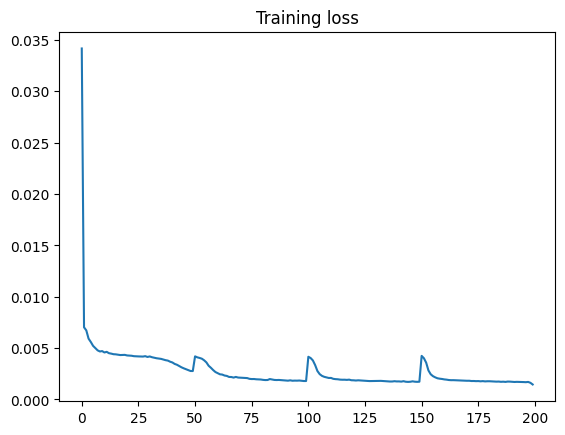

In [67]:
plt.plot(train_loss)
plt.title('Training loss')
plt.show()

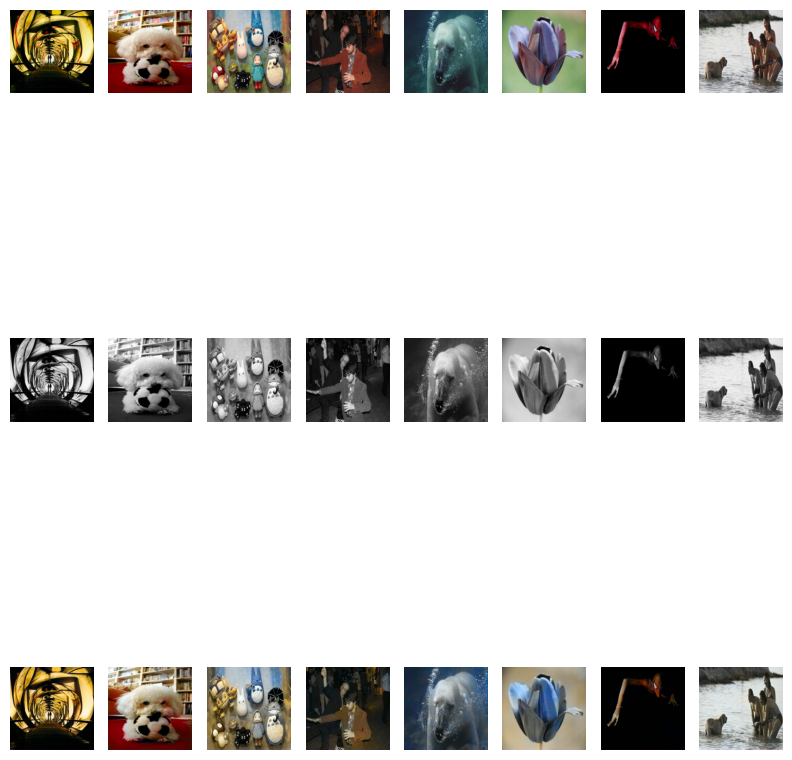

In [68]:
plt.figure(figsize=(10, 10))
for i in range(8):
  plt.subplot(3, 10, i + 1)
  plt.imshow(convert_to_rgb(lab[i], gray[i]))
  plt.axis('off')

  plt.subplot(3, 10, i + 11)
  plt.imshow(gray[i].permute(2, 1, 0).detach().cpu().numpy(), cmap = 'gray')
  plt.axis('off')

  plt.subplot(3, 10, i + 21)
  plt.imshow(convert_to_rgb(logits[i], gray[i]))
  plt.axis('off')

plt.tight_layout()
plt.show()

# Model Testing

In [69]:
with torch.no_grad():
  model.eval()
  total_loss = 0
  test_losses = []

  for gray, lab in test_loader:
    logits = model(gray.to(device))
    loss = loss_fn(logits, lab.to(device))
    total_loss += loss.item()
    test_losses.append(total_loss)

print(f'Test loss is {total_loss / len(test_loader)}')

Test loss is 0.004495230544641425


In [70]:
test = next(iter(test_loader))

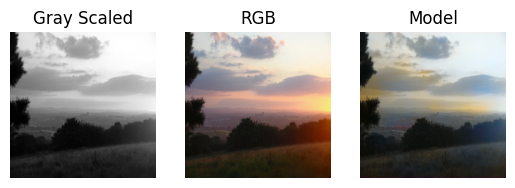

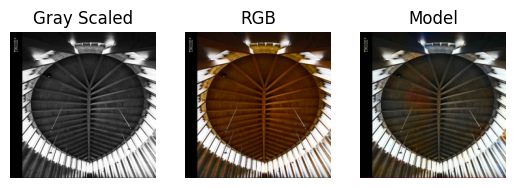

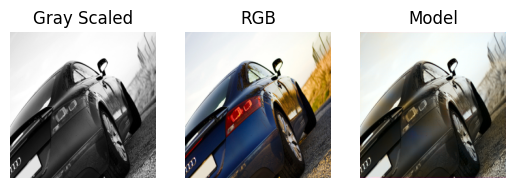

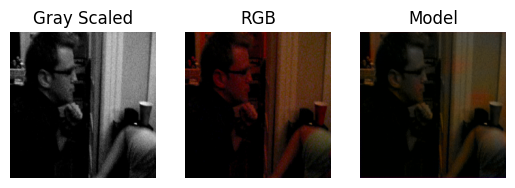

In [74]:
for i in range(logits.shape[0]):
  plt.subplot(1, 3, 1)
  plt.imshow(gray[i].permute(2, 1, 0).detach().cpu().numpy(), cmap = 'gray')
  plt.title('Gray Scaled')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(convert_to_rgb(lab[i], gray[i]))
  plt.title('RGB')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(convert_to_rgb(logits[i], gray[i]))
  plt.title('Model')
  plt.axis('off')

  plt.show()

In [72]:
torch.save(model.state_dict(), '/content/image_colorization.pth')